<a href="https://colab.research.google.com/github/KelvinLam05/Binary-Text-Classification/blob/main/Binary_Classification_of_Vague_Room_Rental_Ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

In this notebook, we will build a simple, fast, and accurate English-language text classification model with minimal effort. More specifically, we will build a model that classifies New York room rental ads as either vague or not.

**Data set information**

The dataset consist of house and commercial space ads from various sources.These ads are classified as vague or not according to the description posted by the people.

**Attribute information**

The dataset consist of two columns - description given by the people and vague or not. Vague ads are labelled as 0.

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text
from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset
df = pd.read_csv('/content/room-rental-ads.csv')

In [ ]:
# Examine the data
df.head()

,Description,Vague/Not
0,Room for rent - Available September 1st ... un...,1.0
1,Available now. Students welcome.\nRent $2700 p...,1.0
2,"3 bedrooms, 2 bathrooms at Bayview/John. Thorn...",1.0
3,"Available now. Rent includes laundry, internet...",0.0
4,"1 Bedroom + Den | 1 Bathroom, Upgraded Kitchen...",1.0


In [ ]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  841 non-null    object 
 1   Vague/Not    825 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB


**Preprocessing**

In [ ]:
# Checking for missing values
df.isnull().sum().sort_values(ascending = False)

Vague/Not      18
Description     2
dtype: int64

In [ ]:
# Drop rows with NaN values
df.dropna(inplace = True)

In [ ]:
# Checking the distribution of classes
df['Vague/Not'].value_counts() 

0.0    438
1.0    385
Name: Vague/Not, dtype: int64

We can say that the number of vague values and not vague values are approximately same.

In [ ]:
# Converting the column Vague/Not to an int 
df['Vague/Not'].map(int)

0      1
1      1
2      1
3      0
4      1
      ..
838    1
839    0
840    0
841    0
842    0
Name: Vague/Not, Length: 823, dtype: int64

**Split the train and test data**

In [ ]:
X = df.drop(['Vague/Not'], axis = 1)

In [ ]:
y = df['Vague/Not']

In [ ]:
# Isolate X and y variables, and perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

**Preprocess data and build a transformer model**

In [ ]:
# Transformer model
MODEL_NAME = 'albert-base-v2' 

In [ ]:
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = [0, 1])

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['Description'])
X_tr = X_tr['Description'].tolist()

In [ ]:
y_tr = pd.DataFrame(data = y_train, columns = ['Vague/Not'])
y_tr = y_tr['Vague/Not'].tolist()

In [ ]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['Description'])
X_te = X_te['Description'].tolist()

In [ ]:
y_te = pd.DataFrame(data = y_test, columns = ['Vague/Not'])
y_te = y_te['Vague/Not'].tolist()

In [ ]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 115
	95percentile : 346
	99percentile : 467


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 132
	95percentile : 363
	99percentile : 522


In [ ]:
# Model classifier
model = t.get_classifier()

Downloading:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

In [ ]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

To train the model, we will first find the optimal learning rate that suits well to our problem. ktrain provides a very good method named lr_find which trains the model at different learning rates and plots loss of the model as the learning rate is increased.

In [ ]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 5) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
109/109 [==============================] - 151s 1s/step - loss: 0.6886 - accuracy: 0.5260
Epoch 2/5
109/109 [==============================] - 135s 1s/step - loss: 0.6453 - accuracy: 0.6043
Epoch 3/5
109/109 [==============================] - 134s 1s/step - loss: 0.8046 - accuracy: 0.5107
Epoch 4/5
109/109 [==============================] - 86s 784ms/step - loss: 6.5738 - accuracy: 0.5263


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


The learning rate plot can be observed by calling the following method:

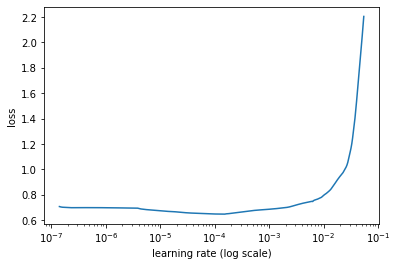

In [ ]:
# Visually identify best learning rate
learner.lr_plot()

We can observe that the classifier provides minimal loss when the learning rate is 5.5e-5.

We will now train the model using the autofit method. The method trains the classifier and automatically selects the best performing one preventing underfitting and overfitting of the model.

In [ ]:
# Training using the 1cycle policy
learner.autofit(5.5e-5, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5.5e-05...
Epoch 1/1024
110/110 [==============================] - 167s 1s/step - loss: 0.6582 - accuracy: 0.6064 - val_loss: 0.5745 - val_accuracy: 0.7273
Epoch 2/1024
110/110 [==============================] - 149s 1s/step - loss: 0.6268 - accuracy: 0.6641 - val_loss: 0.5534 - val_accuracy: 0.7394
Epoch 3/1024
110/110 [==============================] - 149s 1s/step - loss: 0.5688 - accuracy: 0.7340 - val_loss: 0.5107 - val_accuracy: 0.7636
Epoch 4/1024
110/110 [==============================] - 149s 1s/step - loss: 0.5601 - accuracy: 0.7082 - val_loss: 0.5196 - val_accuracy: 0.7697
Epoch 5/1024
110/110 [==============================] - 149s 1s/step - loss: 0.5253 - accuracy: 0.7538 - val_loss: 0.4965 - val_accuracy: 0.7455
Epoch 6/1024
110/110 [==============================] - 149s 1s/step - loss: 0.5129 - accuracy: 0.7462 - val_loss: 0.5164 - val_accuracy: 0.

**Evaluate/Inspect model**

In [ ]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        80
           1       0.74      0.79      0.76        85

    accuracy                           0.75       165
   macro avg       0.75      0.74      0.74       165
weighted avg       0.75      0.75      0.74       165



array([[56, 24],
       [18, 67]])

We are able to achieve a validation accuracy of 75%.

**Preprocess data and build a transformer model**

In [ ]:
# Transformer model
MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.2'  

In [ ]:
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = [0, 1])

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

In [ ]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['Description'])
X_tr = X_tr['Description'].tolist()

In [ ]:
y_tr = pd.DataFrame(data = y_train, columns = ['Vague/Not'])
y_tr = y_tr['Vague/Not'].tolist()

In [ ]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['Description'])
X_te = X_te['Description'].tolist()

In [ ]:
y_te = pd.DataFrame(data = y_test, columns = ['Vague/Not'])
y_te = y_te['Vague/Not'].tolist()

In [ ]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 115
	95percentile : 346
	99percentile : 467


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 132
	95percentile : 363
	99percentile : 522


In [ ]:
# Model classifier
model = t.get_classifier()

404 Client Error: Not Found for url: https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/tf_model.h5
/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:1067: UserWarning: Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn('Could not find Tensorflow version of model.  Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. ' +\


Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

In [ ]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 5) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
109/109 [==============================] - 160s 1s/step - loss: 0.6900 - accuracy: 0.5459
Epoch 2/5
109/109 [==============================] - 142s 1s/step - loss: 0.6486 - accuracy: 0.6411
Epoch 3/5
109/109 [==============================] - 142s 1s/step - loss: 0.8081 - accuracy: 0.5031
Epoch 4/5
109/109 [==============================] - 106s 972ms/step - loss: 4.8490 - accuracy: 0.5163


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


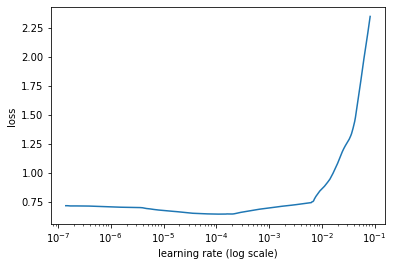

In [ ]:
# Visually identify best learning rate
learner.lr_plot()

In [ ]:
# Training using the 1cycle policy
learner.autofit(1e-4, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
110/110 [==============================] - 168s 1s/step - loss: 0.6301 - accuracy: 0.6459 - val_loss: 0.5533 - val_accuracy: 0.7697
Epoch 2/1024
110/110 [==============================] - 154s 1s/step - loss: 0.6139 - accuracy: 0.6429 - val_loss: 0.6826 - val_accuracy: 0.4848
Epoch 3/1024
110/110 [==============================] - 154s 1s/step - loss: 0.6445 - accuracy: 0.6094 - val_loss: 0.6524 - val_accuracy: 0.6000

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
Epoch 4/1024
110/110 [==============================] - 154s 1s/step - loss: 0.5845 - accuracy: 0.6337 - val_loss: 0.6217 - val_accuracy: 0.6424
Epoch 5/1024
110/110 [==============================] - 154s 1s/step - loss: 0.5574 - accuracy: 0.6763 - val_loss: 0.6972 - val_accuracy: 0.5697

Epoch 00005: Reducing Max LR on Plateau: new max

**Evaluate/Inspect model**

In [ ]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

           0       0.74      0.80      0.77        80
           1       0.80      0.74      0.77        85

    accuracy                           0.77       165
   macro avg       0.77      0.77      0.77       165
weighted avg       0.77      0.77      0.77       165



array([[64, 16],
       [22, 63]])

We are able to achieve a validation accuracy of 77%.

**Preprocess data and build a transformer model**

In [ ]:
# Transformer model
MODEL_NAME = 'distilbert-base-uncased'  

In [ ]:
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = [0, 1])

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['Description'])
X_tr = X_tr['Description'].tolist()

In [ ]:
y_tr = pd.DataFrame(data = y_train, columns = ['Vague/Not'])
y_tr = y_tr['Vague/Not'].tolist()

In [ ]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['Description'])
X_te = X_te['Description'].tolist()

In [ ]:
y_te = pd.DataFrame(data = y_test, columns = ['Vague/Not'])
y_te = y_te['Vague/Not'].tolist()

In [ ]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 115
	95percentile : 346
	99percentile : 467


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 132
	95percentile : 363
	99percentile : 522


In [ ]:
# Model classifier
model = t.get_classifier()

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

In [ ]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

In [ ]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 5) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
109/109 [==============================] - 81s 652ms/step - loss: 0.6912 - accuracy: 0.5214
Epoch 2/5
109/109 [==============================] - 71s 656ms/step - loss: 0.6424 - accuracy: 0.6150
Epoch 3/5
109/109 [==============================] - 71s 653ms/step - loss: 0.7549 - accuracy: 0.5506
Epoch 4/5
109/109 [==============================] - 55s 506ms/step - loss: 5.3858 - accuracy: 0.5039


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


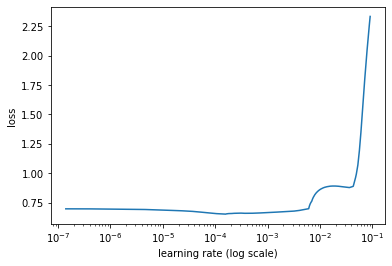

In [ ]:
# Visually identify best learning rate
learner.lr_plot()

In [ ]:
# Training using the 1cycle policy
learner.autofit(1e-4, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
110/110 [==============================] - 89s 727ms/step - loss: 0.6397 - accuracy: 0.6109 - val_loss: 0.5218 - val_accuracy: 0.7758
Epoch 2/1024
110/110 [==============================] - 78s 705ms/step - loss: 0.5866 - accuracy: 0.6702 - val_loss: 0.5653 - val_accuracy: 0.7212
Epoch 3/1024
110/110 [==============================] - 77s 702ms/step - loss: 0.5740 - accuracy: 0.7143 - val_loss: 0.5790 - val_accuracy: 0.6848

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
Epoch 4/1024
110/110 [==============================] - 78s 704ms/step - loss: 0.4974 - accuracy: 0.7766 - val_loss: 0.5365 - val_accuracy: 0.7394
Epoch 5/1024
110/110 [==============================] - 78s 705ms/step - loss: 0.4398 - accuracy: 0.8055 - val_loss: 0.5456 - val_accuracy: 0.7212

Epoch 00005: Reducing Max LR on Platea

**Evaluate/Inspect model**

In [ ]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

           0       0.79      0.72      0.76        80
           1       0.76      0.82      0.79        85

    accuracy                           0.78       165
   macro avg       0.78      0.77      0.77       165
weighted avg       0.78      0.78      0.78       165



array([[58, 22],
       [15, 70]])

We are able to achieve a validation accuracy of 78%.

**Preprocess data and build a transformer model**

In [ ]:
# Transformer model
MODEL_NAME = 'google/electra-base-generator'  

In [ ]:
t = text.Transformer(MODEL_NAME, maxlen = 500, class_names = [0, 1])

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [ ]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['Description'])
X_tr = X_tr['Description'].tolist()

In [ ]:
y_tr = pd.DataFrame(data = y_train, columns = ['Vague/Not'])
y_tr = y_tr['Vague/Not'].tolist()

In [ ]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['Description'])
X_te = X_te['Description'].tolist()

In [ ]:
y_te = pd.DataFrame(data = y_test, columns = ['Vague/Not'])
y_te = y_te['Vague/Not'].tolist()

In [ ]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 115
	95percentile : 346
	99percentile : 467


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:616: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 132
	95percentile : 363
	99percentile : 522


In [ ]:
# Model classifier
model = t.get_classifier()

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [ ]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

In [ ]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 5) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
109/109 [==============================] - 58s 379ms/step - loss: 0.6925 - accuracy: 0.5443
Epoch 2/5
109/109 [==============================] - 41s 380ms/step - loss: 0.6892 - accuracy: 0.5537
Epoch 3/5
109/109 [==============================] - 41s 379ms/step - loss: 0.6999 - accuracy: 0.5230
Epoch 4/5
109/109 [==============================] - 41s 378ms/step - loss: 0.9623 - accuracy: 0.5169
Epoch 5/5
109/109 [==============================] - 41s 378ms/step - loss: 1.3217 - accuracy: 0.5215


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


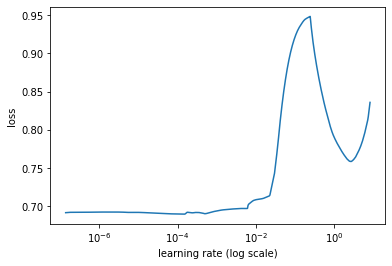

In [ ]:
# Visually identify best learning rate
learner.lr_plot()

In [ ]:
# Training using the 1cycle policy
learner.autofit(1e-4, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
110/110 [==============================] - 61s 419ms/step - loss: 0.6886 - accuracy: 0.5578 - val_loss: 0.7059 - val_accuracy: 0.4848
Epoch 2/1024
110/110 [==============================] - 45s 404ms/step - loss: 0.6875 - accuracy: 0.5304 - val_loss: 0.6768 - val_accuracy: 0.4848
Epoch 3/1024
110/110 [==============================] - 45s 404ms/step - loss: 0.6729 - accuracy: 0.5486 - val_loss: 0.6781 - val_accuracy: 0.6848
Epoch 4/1024
110/110 [==============================] - 45s 404ms/step - loss: 0.6715 - accuracy: 0.5897 - val_loss: 0.7004 - val_accuracy: 0.4848

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
Epoch 5/1024
110/110 [==============================] - 45s 404ms/step - loss: 0.6830 - accuracy: 0.5441 - val_loss: 0.7016 - val_accuracy: 0.4848
Epoch 6/1024
110/110 [=================

**Evaluate/Inspect model**

In [ ]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

           0       0.76      0.68      0.72        80
           1       0.72      0.80      0.76        85

    accuracy                           0.74       165
   macro avg       0.74      0.74      0.74       165
weighted avg       0.74      0.74      0.74       165



array([[54, 26],
       [17, 68]])

We are able to achieve a validation accuracy of 74%.

**Conclusion**

The best result among all the four models we trained belongs to DistilBERT by 78% validation accuracy. Classification report of this model for test data showed that we were getting minimum f1 score from 0.76 up to 0.79 for one of the categories.